## Download reqd

In [2]:
# %pip install opencv-python

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import os

for dirname, _, _ in os.walk('DATASET'):
        print(dirname)

DATASET
DATASET/TEST
DATASET/TEST/R
DATASET/TEST/O
DATASET/DATASET
DATASET/DATASET/TEST
DATASET/DATASET/TEST/R
DATASET/DATASET/TEST/O
DATASET/DATASET/TRAIN
DATASET/DATASET/TRAIN/R
DATASET/DATASET/TRAIN/O
DATASET/TRAIN
DATASET/TRAIN/R
DATASET/TRAIN/O


In [4]:
train_path = "DATASET/TRAIN"
test_path = "DATASET/TEST"

## Import Libraries

In [5]:
from tensorflow import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import plot_model
from glob import glob

## Visualization

In [6]:
import os

# Loads images into array x_data; loads images' corresponding labels into array y_data.
x_data = []
y_data = []

# Filter images according to these extensions
valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        # Verify if the file has a valid image extension
        if any(file.lower().endswith(ext) for ext in valid_image_extensions):
            img_array = cv2.imread(file)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            x_data.append(img_array)
            y_data.append(category.split("/")[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 12565/12565 [00:03<00:00, 3189.20it/s]


In [7]:
# Total images, Total classes

data.shape

(22564, 2)

In [8]:
# Class count

from collections import Counter
Counter(y_data)

Counter({'O': 12565, 'R': 9999})

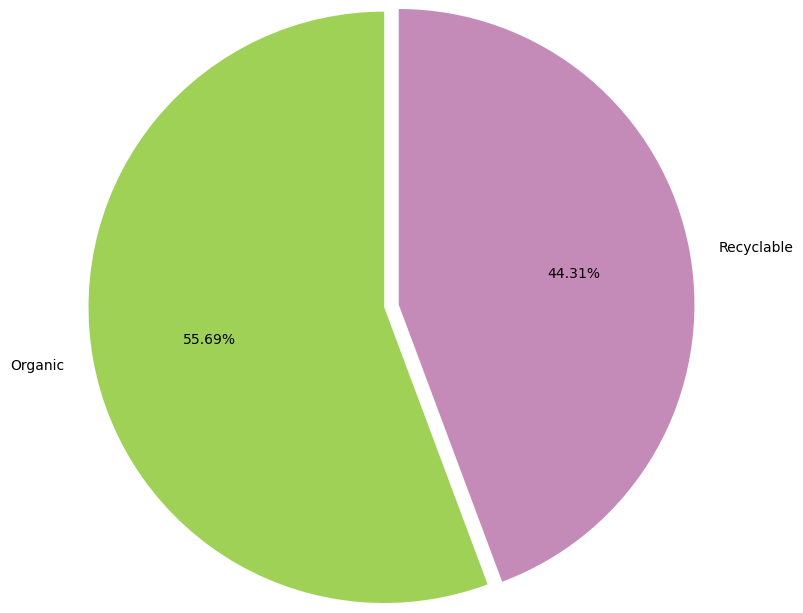

In [9]:
colors = ['#a0d157','#c48bb8']

plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

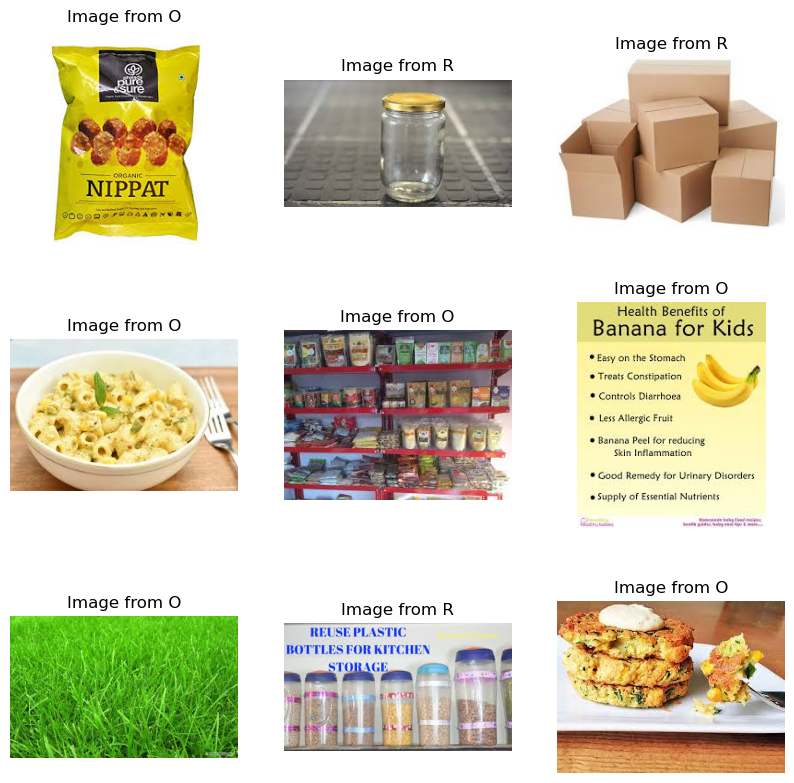

In [10]:
# Set a fixed seed for reproducibility
np.random.seed(42)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    index = np.random.randint(len(data))
    plt.imshow(data.image[index])
    # Prints image's class
    plt.title('Image from {0}'.format(data.label[index]))
    plt.axis("off")

plt.show()


In [11]:
className = glob(train_path + '/*' )
numberOfClass = len(className)

print("Number Of Class(es): ",numberOfClass)

Number Of Class(es):  2


! Add data preprocessing

# Convolutional Neural Network - CNN

## Hyperparameters (adjust accordingly)

In [48]:
img_size = (32, 32)
batch_size = 256
epochs = 10

# Drop niyo legacy; Unoptimized sa device ko yung default, use
# --> optimizers.Adam()
optimizer = optimizers.legacy.Adam()

## Pre-trained model (VGG16)

Note. This VGG16 model's weights were trained on the ImageNet dataset

In [84]:
# Preps VGG16 -> download ~5mins
# No Multilayer Perceptron layer

pre_trained_model = VGG16(
    input_shape = img_size + (3,), 
    include_top = False, 
    weights = 'imagenet'
)

__Note.__ We freeze the convolutional layers to _preserve_ the features the model has already learned from its original, larger dataset (w/c is ImageNet in this case.) Moreover, this allows the model to reduce training time, avoid overfitting, and stabilize training.

In [85]:
# Freeze the convolutional layers
for layer in pre_trained_model.layers:
    layer.trainable = False

### Applying mixed precision

In [86]:
# Adjust policy based on testing;
# Test mixed_float16, mixed_bfloat16, or float32.

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Mixed Precision
# optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

In [87]:
# Create a Sequential model using the pre-trained base model
model = Sequential()

model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = optimizer, 
    metrics = ['accuracy']
)

## Kaggle Sample Model (unused)

In [88]:
# # Note. input_shape == img_size

# model = Sequential()

# model.add(keras.Input(shape = img_size + (3,)))

# # model.add(Conv2D(32,(3,3),input_shape = (64,64,3)))
# model.add(Conv2D(32,(3,3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D())

# model.add(Conv2D(64,(3,3)))  
# model.add(Activation("relu"))
# model.add(MaxPooling2D())

# model.add(Conv2D(128,(3,3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D())

# model.add(Flatten())
# model.add(Dense(256))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(64))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(numberOfClass)) # output
# model.add(Activation("sigmoid"))

# # Note. Optimizer: Adam w/ default learning rate (0.001)
# model.compile(loss = "binary_crossentropy",
#               optimizer = optimizer,
#               metrics = ["accuracy"])

## Model Summary

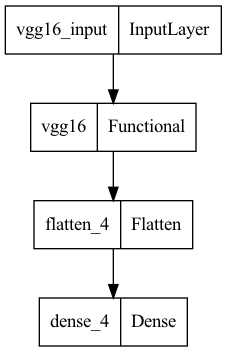

In [89]:
plot_model(model)

In [90]:
# VGG16 model

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

## DirectoryIterators Datasets (unused)

In [91]:
# train_datagen = ImageDataGenerator(rescale= 1./255)

In [92]:
# test_datagen = ImageDataGenerator(rescale= 1./255)

In [93]:
# train_generator = train_datagen.flow_from_directory(
#         train_path, 
#         target_size = img_size,
#         batch_size = batch_size,
#         color_mode = "rgb",
#         class_mode = "categorical")

# test_generator = test_datagen.flow_from_directory(
#         test_path, 
#         target_size = img_size,
#         batch_size = batch_size,
#         color_mode = "rgb",
#         class_mode = "categorical")

## TensorFlow Datasets

In [94]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_path,
        # seed = 1337,
        image_size = img_size,
        batch_size = batch_size,
        # subset = 'training',
        # color_mode = 'rgb',
        # labels = 'inferred',
        label_mode = 'binary'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_path,
        # seed = 1337,
        image_size = img_size,
        batch_size = batch_size,
        # subset = 'validation',
        # color_mode = 'rgb',
        # labels = 'inferred',
        label_mode = 'binary'
)

Found 22564 files belonging to 2 classes.
Found 2513 files belonging to 2 classes.


## Training

In [95]:
# hist = model.fit_generator(
#         generator = train_generator,
#         epochs = 10,
#         validation_data = test_generator)

hist = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/10
57/89 [==================>...........] - ETA: 1:20 - loss: 5.1065 - accuracy: 0.7267

KeyboardInterrupt: 

## Visualization of Results

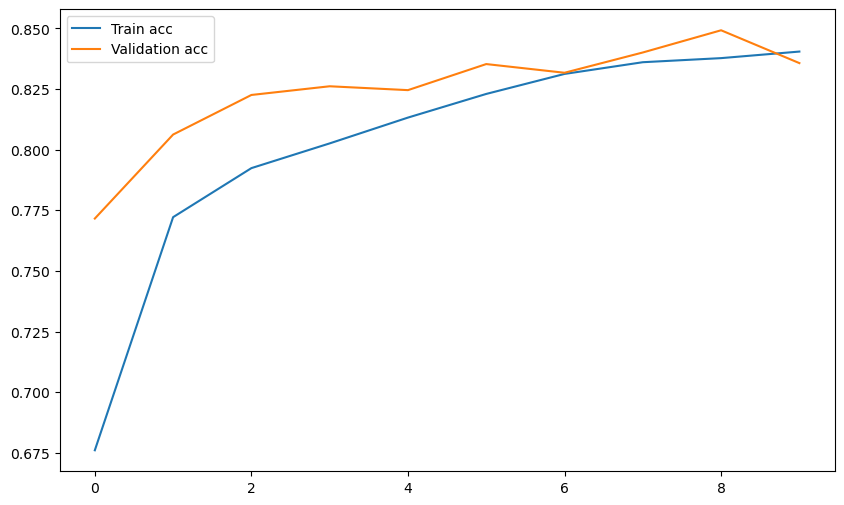

In [ ]:
plt.figure(figsize = [10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

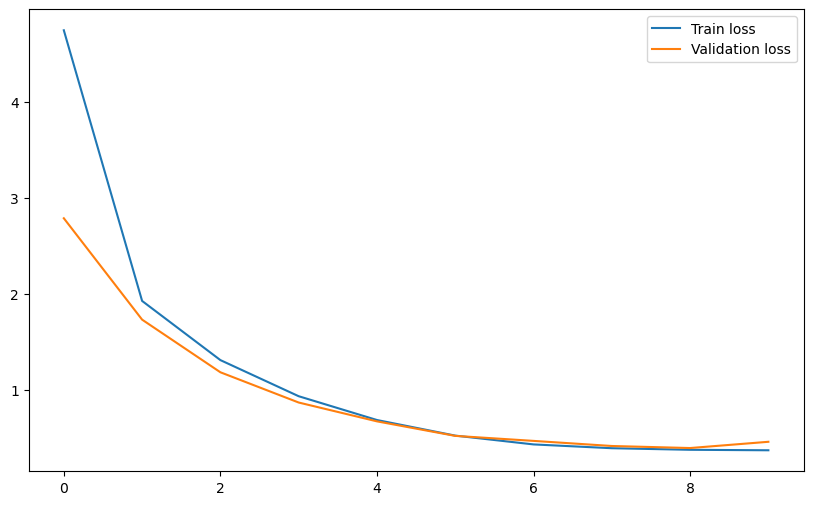

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## Model Prediction

In [ ]:
accuracy = model.evaluate(val_ds)

10/10 [==============================] - 10s 972ms/step - loss: 0.4613 - accuracy: 0.8357


In [ ]:
predictions = model.predict(val_ds)

10/10 [==============================] - 13s 1s/step


In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(val_ds)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%\n')

# Predictions on the test dataset
predictions = model.predict(val_ds)

# Display some sample predictions
for i in range(min(5, len(predictions))):
    print(f"Example {i + 1}:")
    print(f"Predicted probabilities: {predictions[i]}")
    print(f"Predicted class: {tf.argmax(predictions[i]).numpy()}")
    print("-----")

10/10 [==============================] - 17s 2s/step - loss: 0.4612 - accuracy: 0.8357
Test Loss: 0.4612
Test Accuracy: 83.57%

10/10 [==============================] - 27s 3s/step
Example 1:
Predicted probabilities: [0.0556]
Predicted class: 0
-----
Example 2:
Predicted probabilities: [0.708]
Predicted class: 0
-----
Example 3:
Predicted probabilities: [0.988]
Predicted class: 0
-----
Example 4:
Predicted probabilities: [0.986]
Predicted class: 0
-----
Example 5:
Predicted probabilities: [0.994]
Predicted class: 0
-----


In [ ]:
# Note. Adjust to preset image size
    # img = cv2.resize(img, img_size)
    # img = np.reshape(img, [-1, 32, 32,3])

def predict_func(img): 
    plt.figure(figsize = (6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, img_size)
    img = np.reshape(img, [-1, 32, 32,3])
    result = np.argmax(model.predict(img))
    
    if result == 0: print("\033[94m" + "This image -> Recyclable" + "\033[0m")
    elif result == 1: print("\033[94m" + "This image -> Organic" + "\033[0m")

1/1 [==============================] - 0s 387ms/step
This image -> Recyclable


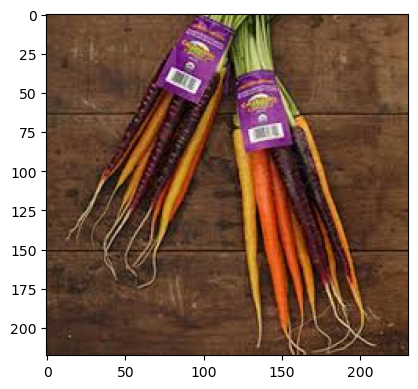

In [ ]:
test_img = cv2.imread("DATASET/TEST/O/O_12573.jpg")
# test_img = cv2.imread("./test_prediction/eraser.png")
predict_func(test_img)

1/1 [==============================] - 0s 54ms/step
This image -> Recyclable


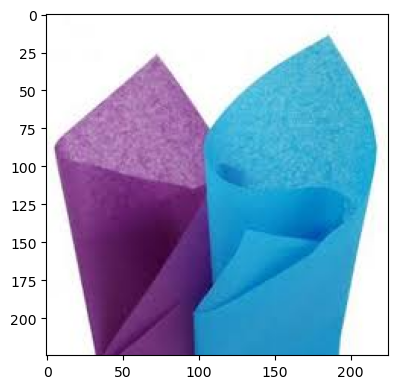

In [ ]:
test_img2 = cv2.imread("DATASET/TEST/R/R_10753.jpg")
# test_img2 = cv2.imread("./test_prediction/tissue-roll.png")
predict_func(test_img2)

1/1 [==============================] - 0s 64ms/step
This image -> Recyclable


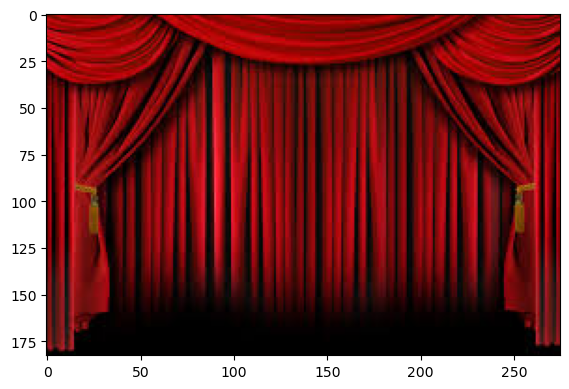

In [ ]:
test_img3 = cv2.imread("DATASET/TEST/R/R_10168.jpg")
# test_img3 = cv2.imread("./test_prediction/poptart.png")
predict_func(test_img3)

1/1 [==============================] - 0s 93ms/step
This image -> Recyclable


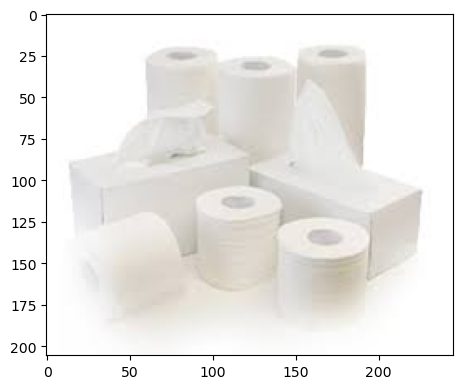

In [ ]:
test_img4 = cv2.imread("DATASET/TEST/R/R_10762.jpg")
# test_img4 = cv2.imread("./test_prediction/paper-bag.png")
predict_func(test_img4)

1/1 [==============================] - 0s 59ms/step
This image -> Recyclable


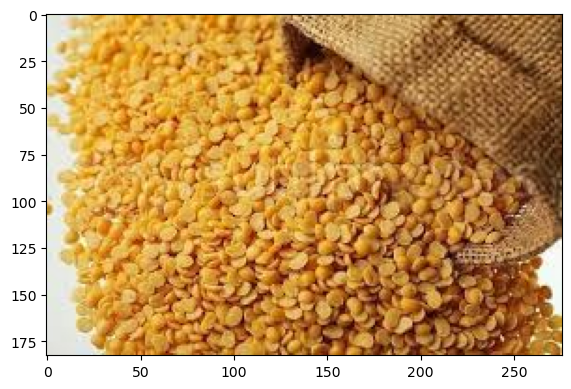

In [ ]:
test_img5 = cv2.imread("DATASET/TEST/O/O_13487.jpg")
# test_img5 = cv2.imread("./test_prediction/banana.png")
predict_func(test_img5)